In [1]:
include("src/SimFunctions.jl")

Dict{String, IntegrationParameters} with 5 entries:
  "slow"       => IntegrationParameters(1000, "MC", 1)
  "fast"       => IntegrationParameters(100, "MC", 1)
  "very_slow"  => IntegrationParameters(10000, "MC", 1)
  "ultra_slow" => IntegrationParameters(100000, "MC", 1)
  "very_fast"  => IntegrationParameters(10, "MC", 1)

In [2]:
include("src/PlotFunctions.jl")

plot_spectral_weight

In [3]:
""" 
Plots the spectral weight (either the S+S- correlation, or something else)
stored in the simulation stored at the specified path.
"""
function plot_spectral_weight(data::Dict, which="Spm";
        clamp_lo=-Inf, clamp_hi = Inf,
        colorscale=:linear,
        show_bounds=false
    )
    d = data["intensity"]

    zdata = clamp.(real.(d[which])', clamp_lo, clamp_hi)
    if colorscale == :log
        zdata = log10.(zdata)
    end
    
    p = heatmap(d["tau"],d["W"],zdata)
    if show_bounds
        plot!(d["tau"], d["bounds"], linecolor=:white)
    end
    xticks!(d["ticks_tau"],d["ticks_label"])
    plot!(legend=nothing)

    sim =data["physical_parameters"]

    B = sim["B"]
    vline!(d["ticks_tau"], linecolor=:white, linestyle=:dash)
    
    bstr = @sprintf("[%.3f,%.3f,%.3f]",B[1],B[2],B[3])  
    if norm( abs.(B/norm(B))- [1,1,1]/√3) < 1e-8
        bstr = @sprintf("%.3f [1,1,1]/\\sqrt{3}", norm(B) )
    elseif norm( abs.(B/norm(B))- [1,1,0]/√2) < 1e-8
        bstr = @sprintf("%.3f [1,1,0]/\\sqrt{2}", norm(B))
    end
    title!(@sprintf("\$J_\\pm=%.3fJ_{yy}, B=%s J_{yy}\$",sim["Jpm"],bstr))
    return p
end

plot_spectral_weight

# Setting up the path and basic input parameters

In [4]:
k_density_spinon_dispersion=60
k_density_specweight=20

G = @SMatrix [0. 0. 0.;
	 0. 0. 0.;
	 1. 0. 0.]


Jpm = 0.03
Bmin =sqrt(9*Jpm/5)
println("minimum B = ",Bmin)


lat112 = geom.PyroPrimitive(1,1,2)

sim_repo = Dict(
       "pipi00" => SimulationParameters("pipi00",
         lattice=lat112,
         A=construct_landau_gauge(lat112, [0 0 0 0; 0 0 0 0; π 0 0 0]),
         Jpm=Jpm,
         B=0.4*[1,1,0]/√2,
         n_samples = 10000
     ),
     "0flux" => SimulationParameters("0flux",
        lattice=geom.PyroPrimitive(1,1,1),
        A=[0 0 0 0],
        Jpm=-0.03,
        B=-0.4*[1,1,0]/√2,
        n_samples = 10000
    )
    )


minimum B = 0.23237900077244503


Dict{String, SimulationParameters} with 2 entries:
  "pipi00" => SimulationParameters([0.0 0.0 0.0 0.0; 3.14159 0.0 0.0 0.0], 0.03…
  "0flux"  => SimulationParameters([0.0 0.0 0.0 0.0], -0.03, [-0.282843, -0.282…

In [5]:
calc_fluxes(sim_repo["pipi00"])

2×4 Matrix{Float64}:
 0.0  -3.14159   3.14159  0.0
 0.0   3.14159  -3.14159  0.0

In [6]:
[2-(-p'*[1.,1.,0.])^2  for p in geom.pyro]

4-element Vector{Float64}:
 -2.0
  2.0
  2.0
 -2.0

In [7]:
csim_repo = Dict( k=>CompiledModel(s) for (k,s) in sim_repo)


Dict{String, CompiledModel} with 2 entries:
  "pipi00" => CompiledModel(SimulationParameters([0.0 0.0 0.0 0.0; 3.14159 0.0 …
  "0flux"  => CompiledModel(SimulationParameters([0.0 0.0 0.0 0.0], -0.03, [-0.…

In [8]:
calc_fluxes(sim_repo["pipi00"])

2×4 Matrix{Float64}:
 0.0  -3.14159   3.14159  0.0
 0.0   3.14159  -3.14159  0.0

In [9]:

hsp_std = Dict(
    "\\Gamma" =>[0.,   0.,   0.  ],
    "X" =>      [0.,   1.,   0.  ],
    "L" =>      [1/2,  1/2,  1/2 ],
    "W" =>      [1/2,  1.,   0   ],
    "U" =>      [1/4,  1,    1/4 ],
    "K" =>      [0.75, 0.75, 0. ]
    )
    

# high_symmetry_points_Toronto = Dict(
#     "\\Gamma"=> [0.,0.,0.],
#     "X"=> [0.,1.,0.],
#     "W"=> [0.,1.,-0.5], # probably needs 
#     "K"=> [0.5,0.5,-0.5], # this is L, right
#     # "K"=> [0.75,0, 0.75],
#     "L"=> [0.5,0.5,0.5], 
#     "W'"=> [1.,0.5,0.],
#     "X'"=> [1.,0.,0.],
#     "U"=> [1.0, 0.25,0.25]
# )

high_symmetry_points_Toronto = Dict(
    "\\Gamma"=> [0.,0.,0.],
    "X"=> [0.,1.,0.],
    "W"=> [-0.5,1., 0],
    # "K"=> [ 0., 0.75, 0.75],
    # "K"=> [0.75, 0., 0.75],
    "K"=> [-0.75, 0.75, 0.],
    "L"=> [0.5,0.5,0.5], 
    "U"=> [0.25,0.25,1.0],
    "W'"=> [0.,0.5,1.],
    "X'"=> [0.,0.,1.]
)

high_symmetry_points_Toronto_2 = Dict(
    "\\Gamma"=> [0.,0.,0.],
    "X"=> [0.,1.,0.],
    "W"=> [0.5,1., 0],
    "K"=> [0.75, 0.75, 0.],
    "L"=> [0.5,0.5,0.5], 
    "U"=> [0.25,0.25,1.0],
    "W'"=> [0.,0.5,1.],
    "X'"=> [0.,0.,1.]
)


# points = split("\\Gamma X W K \\Gamma L U W")
points = split("\\Gamma X W K \\Gamma L U W' X' \\Gamma")

path_Toronto = generate_path(high_symmetry_points_Toronto, 
	    points, 
		points_per_unit=k_density_spinon_dispersion, K_units=2π/8)




BZPath([0.0, 0.0, 0.01308996938995747, 0.02617993877991494, 0.039269908169872414, 0.05235987755982988, 0.06544984694978735, 0.07853981633974483, 0.0916297857297023, 0.10471975511965977  …  4.787916631755747, 4.801006601145705, 4.814096570535662, 4.82718653992562, 4.840276509315577, 4.853366478705534, 4.866456448095492, 4.879546417485449, 4.892636386875407, 4.905726356265364], [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.01308996938995747, 0.0], [0.0, 0.02617993877991494, 0.0], [0.0, 0.039269908169872414, 0.0], [0.0, 0.05235987755982988, 0.0], [0.0, 0.06544984694978735, 0.0], [0.0, 0.07853981633974483, 0.0], [0.0, 0.0916297857297023, 0.0], [0.0, 0.10471975511965977, 0.0]  …  [0.0, 0.0, 0.11780972450961724], [0.0, 0.0, 0.1047197551196597], [0.0, 0.0, 0.09162978572970237], [0.0, 0.0, 0.07853981633974483], [0.0, 0.0, 0.0654498469497874], [0.0, 0.0, 0.05235987755982985], [0.0, 0.0, 0.039269908169872414], [0.0, 0.0, 0.02617993877991498], [0.0, 0.0, 0.013089969389957545], [0.0, 0.0, 0.0]], [0.0

# Benchmarking against Zhengbang, Félix, and YBK

Computing spinon dispersions...


Spinon Dispersion: 100%|████████████████████████████████| Time: 0:00:00


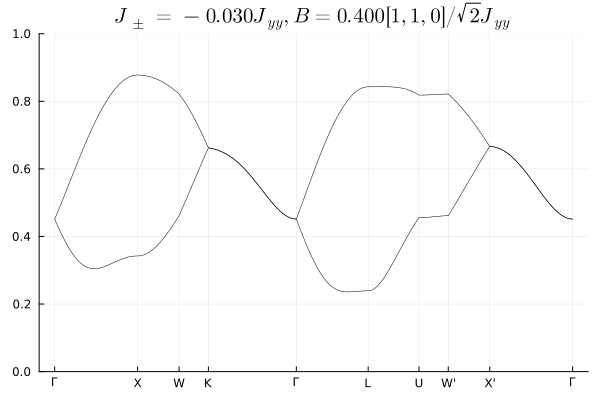

In [10]:
data_dir = "output"

println("Computing spinon dispersions...")
	# compute spinons
d = calc_spinons_along_path(data_dir, csim=csim_repo["0flux"], path=path_Toronto)

	# autorange this based on the spinon dispersion
band_data = load(d)["spinon_dispersion"]["bands"]

data = load(d)

plot_spinons(data)
Qlist = eachcol(data["spinon_dispersion"]["Q_list"])
tlist = data["spinon_dispersion"]["tau"]

shift = q->q+geom.primitive_recip_basis *[0.5,0.,0.]
ylims!(0,1)
save("/Users/alaricsanders/Desktop/test.png", plot!())
plot!()

Spinon Dispersion: 100%|████████████████████████████████| Time: 0:00:00


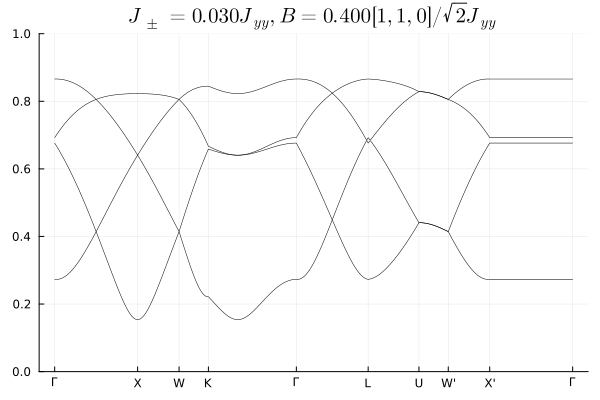

In [58]:

	# compute spinons ππ00

rot_path_Toronto = generate_path(
    # Dict( k => [v[2],v[3],v[1]]  for (k,v) in  high_symmetry_points_Toronto), 
    # Dict( k => [v[3],v[1],v[2]]  for (k,v) in  high_symmetry_points_Toronto), 
    high_symmetry_points_Toronto,
	    points, 
		points_per_unit=500, K_units=2π/8)


d = calc_spinons_along_path(data_dir, csim=csim_repo["pipi00"], path=rot_path_Toronto, 
    kshift=[0.,-π/8,0]-2π/8 * [-0.75,0.75,0])

data = load(d)

plot_spinons(data)

ylims!(0,1)
save("/Users/alaricsanders/Desktop/test2.png", plot!())
plot!()

In [12]:
path_Toronto_2 = generate_path(high_symmetry_points_Toronto_2, 
	    points, 
		points_per_unit=k_density_spinon_dispersion, K_units=2π/8)

integral_params = integration_settings["slow"]
eg = collect(range(0,2, 70));

In [13]:
sim0 = SimulationParameters("0flux",
        lattice=geom.PyroPrimitive(1,1,1),
        A=[0 0 0 0],
        Jpm=-0.03,
        B=[0,0,0],
        n_samples = 10000
    )
csim0 = CompiledModel(sim0)

CompiledModel(SimulationParameters([0.0 0.0 0.0 0.0], -0.03, [0.0, 0.0, 0.0], Main.SpinonStructure.PyrochloreGeometry.PyroPrimitive([1, 1, 1], SVector{3, Int64}[[0, 0, 0], [2, 2, 2]], SVector{3, Int64}[[1, 1, 1], [1, -1, -1], [-1, 1, -1], [-1, -1, 1]]), 2.0, 10000, "0flux"), [2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2], ComplexF64[-0.0075 - 0.0im, -0.0075 - 0.0im, -0.0075 - 0.0im, -0.0075 - 0.0im, -0.0075 - 0.0im, -0.0075 - 0.0im, -0.0075 - 0.0im, -0.0075 - 0.0im, -0.0075 - 0.0im, -0.0075 - 0.0im, -0.0075 - 0.0im, -0.0075 - 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], [0.0 -4.0 … -2.0 -2.0; -4.0 0.0 … 2.0 -2.0; -4.0 -4.0 … -2.0 2.0], 0.13048634946445575)

Spectral weight: 100%|██████████████████████████████████| Time: 0:00:06


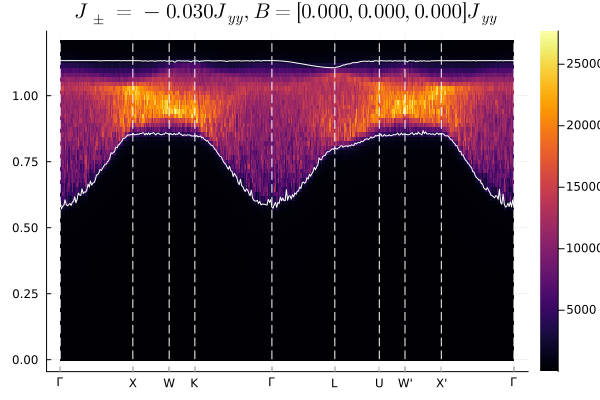

In [64]:
f0 = calc_spectral_weight_along_path(data_dir, 
	    # sim=csim_repo["0flux-doubled"],
        sim=csim0,
	    ip=integral_params, 
	    Egrid=collect(range(0,1.2, 70)), path=path_Toronto
#    g_tensor=G
)

plot_spectral_weight(load(f0),show_bounds=true)

In [15]:
f1 = calc_spectral_weight_along_path(data_dir, 
	    # sim=csim_repo["0flux"],
    sim=csim_repo["pipi00"],
	    ip=integral_params, 
	    Egrid=eg, path=path_Toronto
#    g_tensor=G
)

	    
println("Saving data to ",f1)

Spectral weight: 100%|██████████████████████████████████| Time: 0:04:06


Saving data to output/SQW?name=pipi00?J_pm=0.030?B=[0.283,0.283,0.000].jld


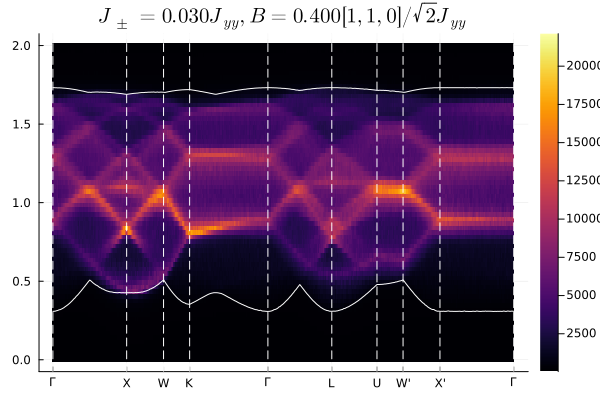

In [66]:
plt = plot_spectral_weight(load(f1),show_bounds=true)

In [85]:
σ = rand(4)*2π
L = sum(σ)/4

Bmat = reduce(vcat,[bμ' for bμ in geom.pyro])

dk = Bmat[1:3,:] \ (σ[1:3] .- L)

println(Bmat * dk - σ )

[-4.971603126788798, -4.971603126788798, -4.971603126788798, -4.9716031267888]


In [23]:


f2 = calc_spectral_weight_along_path(data_dir, 
	    # sim=csim_repo["0flux-doubled"],
        sim=csim_repo["0flux"],
	    ip=integral_params, 
	    Egrid=eg, path=path_Toronto
#    g_tensor=G
)

Spectral weight: 100%|██████████████████████████████████| Time: 0:00:21


"output/SQW?name=0flux?J_pm=-0.030?B=[-0.283,-0.283,-0.000].jld"

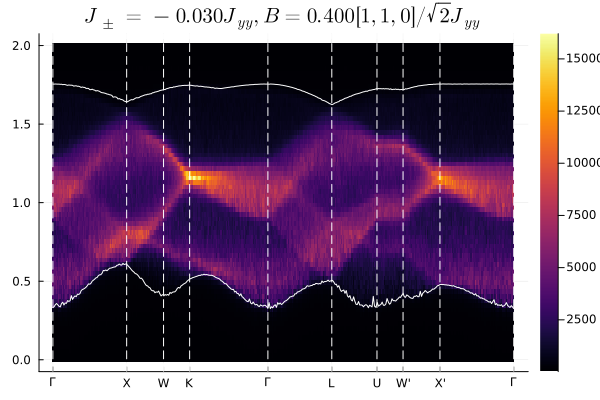

In [63]:
plt = plot_spectral_weight(load(f2),colorscale=:linear,show_bounds=true)

In [19]:
Q = @SVector [0.,0,0]
pxvals = range(0,2π/2,100)
pyvals = range(0,2π/2,100)

S = @. norm(SpinonStructure.corr_at(Q, SVector{3}([pxvals,pyvals,0.]), csim_repo["0flux-doubled"])[2])

heatmap(pxvals,pyvals, S)

LoadError: KeyError: key "0flux-doubled" not found

In [20]:
lattice_gradient(lat112, [1.,0,-1,0])

2×4 Matrix{Float64}:
 2.0  2.0  2.0  1.0
 0.0  0.0  0.0  1.0

In [21]:
lat112 = geom.PyroPrimitive(1,1,2)

Main.SpinonStructure.PyrochloreGeometry.PyroPrimitive([1, 1, 2], SVector{3, Int64}[[0, 0, 0], [4, 4, 0], [2, 2, 2], [6, 6, 2]], SVector{3, Int64}[[1, 1, 1], [1, -1, -1], [-1, 1, -1], [-1, -1, 1], [5, 5, 1], [5, 3, -1], [3, 5, -1], [3, 3, 1]])

In [22]:
lat112.tetra_sites


4-element Vector{SVector{3, Int64}}:
 [0, 0, 0]
 [4, 4, 0]
 [2, 2, 2]
 [6, 6, 2]